In [17]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import timedelta, datetime
#import contextily as ctx

In [18]:
def day_of_year_to_date(day_of_year):
    # Create a date object for January 1st of the given year
    jan_first = datetime(2019, 1, 1)
    # Add the day_of_year - 1 to January 1st to get the correct date
    target_date = jan_first + timedelta(days=day_of_year - 1)
    # Return the month and day
    return target_date.month, target_date.day
day_of_year = 236
month, day = day_of_year_to_date(day_of_year)
print(f"The {day_of_year}th day of 2019 is {month}/{day}.")

The 236th day of 2019 is 8/24.


In [19]:
import psutil

# Get the available memory in bytes
available_memory = psutil.virtual_memory().available

# Convert to gigabytes for easier interpretation
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 179.61 GB


# Open and visualize 1 hour aggregates
### starting with AOD, QA2 
# Trying FRP aggregate

In [20]:
hh = '00'
dd = 250
month = 9
day_MUSICAv0 = 7
day = 6
group_name = 'aod_muri_qa2'

In [21]:
FILE=f"/home/svisaga/clavrx/muri/AGGR_HOURLY_2019{dd:03}T{hh}00_0_25deg_campex_muri.nc"
# Open the root group

C = xarray.open_dataset(FILE, group=group_name)
#C['Mean'].longitude
ds_aod = C
aod = ds_aod['Mean'].data
        # Create a new DataArray for AOD with lon and lat as coordinates
longitude = np.linspace(-180, 180, 1440)  # Longitudes from -180 to 180 with 1440 points
latitude = np.linspace(-90, 90, 720)     # Latitudes from -90 to 90 with 720 points

lat_points = 158 
lon_points = 186
loni = 93.94023627519107
lone = 140.22237665045168
longitude_ = np.linspace(loni,lone,lon_points)
lati = -19.15159944367177
late = 20.152990264255905
latitude_ = np.linspace(lati,late,lat_points)


aodqa_with_coords = xarray.DataArray(
    data=aod.T,  # AOD data values
    dims=['latitude', 'longitude'],   # Specify the dimension names
    coords={'longitude': longitude, 'latitude': latitude},  # Assign coordinates
    name='aod_Mean'  # You can name the DataArray
)
aodqa_with_coords = aodqa_with_coords.sel(latitude=slice(-19.1516, 20.15299+0.25 ),longitude=slice(93.94024-0.25, 140.22238+0.25))
aodqa_with_coords

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[        nan,         nan,         nan, ...,  1.06411874,
        -3.35513396, -1.45820092],
       [        nan,         nan,  0.08605167, ..., -2.61399018,
        -2.49066991, -2.12707988],
       [        nan,         nan,  0.0806189 , ..., -2.04624495,
        -0.92726003, -1.96774194],
       ...,
       [        nan,         nan,         nan, ..., -0.08548773,
        -0.25108551, -0.28184623],
       [        nan,         nan,         nan, ..., -0.05167265,
        -0.15559404, -0.09318619],
       [        nan,         nan,         nan, ..., -0.1839515 ,
        -0.39621646, -0.37304042]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

In [6]:
FILE_MUSICAv0 = f"/home/svisaga/MUSICA_ANALYSES/MUSICAv0_AOD_U_V_regridded/MUSICAv0_AOD_U_V_SEAcut_25km_2019-{month:02}-{day_MUSICAv0:02}-03600.nc"
C_MUSICAv0 = xarray.open_dataset(FILE_MUSICAv0)
C_MUSICAv0 = C_MUSICAv0.sel(time=f'2019-09-{day_MUSICAv0:02}T00:30:00.000000000')
aod_musicav0 = C_MUSICAv0['AODVIS']
aod_musicav0
C_MUSICAv0

<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186, lev: 32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
  * lev      (lev) float32 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
    time     datetime64[ns] 2019-09-07T00:30:00
Data variables:
    AODVIS   (lat, lon) float32 ...
    U        (lat, lon, lev) float32 ...
    V        (lat, lon, lev) float32 ...

In [7]:
for latitude in aodqa_with_coords.latitude:
    for longitude in aodqa_with_coords.longitude:
        if np.isnan(aodqa_with_coords.sel(latitude=latitude, longitude=longitude)):
            aod_musicav0.loc[dict(lat=latitude, lon=longitude)] = np.nan

# Load flight ICT file.

In [8]:
# Load flight track data from CSV file
file_path = f'/home/svisaga/MUSICA_ANALYSES/WWW-AIR_1726704979598/CAMP2EX-MetNav_P3B_2019{month:02}{day:02}_R0.ict'  # Replace with your CSV file path
file_date_str = file_path.split('_')[-2].replace('.csv', '') 
file_date = datetime.strptime(file_date_str, '%Y%m%d')  # Convert to datetime
file_date

data = pd.read_csv(file_path, skiprows=73)
data

# Convert the 'time' column (seconds since midnight) to timedelta and add to file date
data['datetime'] = data['Time_Start'].apply(lambda t: file_date + timedelta(seconds=t))
data

# Extract latitude, longitude, and datetime from the CSV
lats = data['Latitude']
lons = data['Longitude']
datetimes = data['datetime']  # Now a combined datetime column


# Calculate Daily Mean of Hourly mean AOD

In [9]:
group_name_list = ['aod_muri_qa2']
for group_name in group_name_list:
    # Initialize empty DataArrays to store concatenated results
    da_concat = xarray.DataArray([])
    da_concat_model = xarray.DataArray([])
    #for dy in range(236, 274, 1): #change to 279 later..
    for dy in range(236, 238, 1):
        for i in range(0, 9, 1):
            hh = f"{i:02d}"
            dd = f"{dy:03d}"
            FILE=f"/home/svisaga/clavrx/muri/AGGR_HOURLY_2019{dd}T{hh}00_0_25deg_campex_muri.nc"
            # Open the root group
            C = xarray.open_dataset(FILE)
            # Open a specific group, e.g., 'group_name'
            print(dd, group_name)
            ds_aod = xarray.open_dataset(FILE, group=group_name)

            month, day = day_of_year_to_date(dy)

            FILE_MUSICAv0 = f"/home/svisaga/MUSICA_ANALYSES/MUSICAv0_AOD_U_V_regridded/MUSICAv0_AOD_U_V_SEAcut_25km_2019-{month:02}-{day:02}-03600.nc"
            
            C_MUSICAv0 = xarray.open_dataset(FILE_MUSICAv0)
            time_ = f'2019-{month:02}-{day:02}T{hh}:30:00.000000000'
            #print(dy, time_)
            C_MUSICAv0 = C_MUSICAv0.sel(time=time_)
            
            aod_musicav0 = C_MUSICAv0['AODVIS']

            #for figure labels
            file_date_str = FILE.split('/')[-1].replace('.nc', '') .split('T')[0].split('_')[2]
            
            if i>0:
                aod_1 = da_concat #save old timestep AOD to aod_1
                aod_1_model = da_concat_model

            da_concat_ = ds_aod['Mean'].data
            longitude = np.linspace(-180, 180, 1440)  # Longitudes from -180 to 180 with 1440 points
            latitude = np.linspace(-90, 90, 720)     # Latitudes from -90 to 90 with 720 points
            da_concat_hourly = xarray.DataArray(
                data=da_concat_.T,  # AOD data values
                dims=['latitude', 'longitude'],  # Specify the dimension names
                coords={'longitude': longitude, 'latitude': latitude},  # Assign coordinates
                name='aod_Mean'  # You can name the DataArray
            )
            da_concat_hourly = da_concat_hourly.sel(latitude=slice(-19.1516, 20.15299 + 0.25), longitude=slice(93.94024 - 0.25, 140.22238 + 0.25))

            for latitude in da_concat_hourly.latitude:
                for longitude in da_concat_hourly.longitude:
                    value = da_concat_hourly.sel(latitude=latitude, longitude=longitude)
                    if (value < 0):
                        da_concat_hourly.loc[dict(latitude=latitude, longitude=longitude)] = np.nan
                        aod_musicav0.loc[dict(lat=latitude, lon=longitude)] = np.nan
                    if (np.isnan(value)):
                        aod_musicav0.loc[dict(lat=latitude, lon=longitude)] = np.nan
            
            
            da_concat_model_hourly = aod_musicav0

            # Concatenate the hourly data to the main DataArray
            if da_concat.size == 0:
                da_concat = da_concat_hourly.expand_dims(dim='new_dim')
                da_concat_model = da_concat_model_hourly.expand_dims(dim='new_dim')
            else:
                da_concat = xarray.concat([da_concat, da_concat_hourly.expand_dims(dim='new_dim')], dim='new_dim')
                da_concat_model = xarray.concat([da_concat_model, da_concat_model_hourly.expand_dims(dim='new_dim')], dim='new_dim')
 

    mean_aod = da_concat.mean(dim='new_dim', skipna=True)
    print(mean_aod)
    mean_aod_model = da_concat_model.mean(dim='new_dim', skipna=True)   


236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
236 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
237 aod_muri_qa2
<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[0.08266035, 0.08771592, 0.07799375, ..., 0.08769392, 0.0553181 ,
        0.09506713],
       [0.09148405, 0.08003423, 0.07734321, ..., 0.0744914 , 0.0636614 ,
        0.06665474],
       [0.07699582, 0.0707987 , 0.08549277, ..., 0.12486882, 0.13070325,
        0.10507503],
       ...,
       [       nan,        nan,        nan, ..., 0.06924841, 0.06666555,
        0.0477112 ],
       [       nan,        nan,        nan, ..., 0.09963956, 0.08111084,
        0.08219413],
       [       nan,        nan,        nan, ..., 0.09430194, 0.06011608,
        0.04765771]])
Coordinates:
  * longitude  (longitude) float64 93.94 9

In [10]:
'''
# Ensure NaNs in mean_aod match NaNs in mean_aod_model using a for loop
for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        value = mean_aod.sel(latitude=latitude, longitude=longitude)
        if (value < 0):
            mean_aod.loc[dict(latitude=latitude, longitude=longitude)] = np.nan
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan
        if (np.isnan(value)):
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan
'''

'\n# Ensure NaNs in mean_aod match NaNs in mean_aod_model using a for loop\nfor latitude in mean_aod.latitude:\n    for longitude in mean_aod.longitude:\n        value = mean_aod.sel(latitude=latitude, longitude=longitude)\n        if (value < 0):\n            mean_aod.loc[dict(latitude=latitude, longitude=longitude)] = np.nan\n            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan\n        if (np.isnan(value)):\n            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan\n'

In [11]:
da_concat

<xarray.DataArray 'aod_Mean' (new_dim: 18, latitude: 158, longitude: 186)>
array([[[       nan,        nan,        nan, ..., 0.16911659,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.12061467, 0.11872678, 0.12999988, ...,        nan,
                nan,        nan],
        [0.1275358 , 0.12947478, 0.13487001, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.06889553],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.08966338],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.05105216, 0.0467364 , 0.05175029, ...,        nan,
                nan,        nan],
        [0.04408379, 0.03783195, 0.03792538, ...,        nan,
                nan,        nan],
        [0.04644742, 0.0492287 , 0.06285234, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15
Dimensions without coordinates: new_dim

In [12]:
da_concat_model

<xarray.DataArray 'AODVIS' (new_dim: 18, lat: 158, lon: 186)>
array([[[       nan,        nan,        nan, ..., 0.02928238,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.09030784, 0.09030784, 0.0934665 , ...,        nan,
                nan,        nan],
        [0.10054228, 0.10054228, 0.1024067 , ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.05518493],
        [       nan,        nan,        nan, ...,        nan,
                nan, 0.05460488],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.1073231 , 0.1073231 , 0.10741869, ...,        nan,
                nan,        nan],
        [0.10346854, 0.10346854, 0.10244612, ...,        nan,
                nan,        nan],
        [0.10346854, 0.10346854, 0.10244612, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
    time     (new_dim) datetime64[ns] 2019-08-24T00:30:00 ... 2019-08-25T08:3...
Dimensions without coordinates: new_dim
Attributes:
    units:      
    long_name:  Aerosol optical depth 550 nm

In [13]:
import psutil

# Get the available memory in bytes
available_memory = psutil.virtual_memory().available

# Convert to gigabytes for easier interpretation
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 175.19 GB


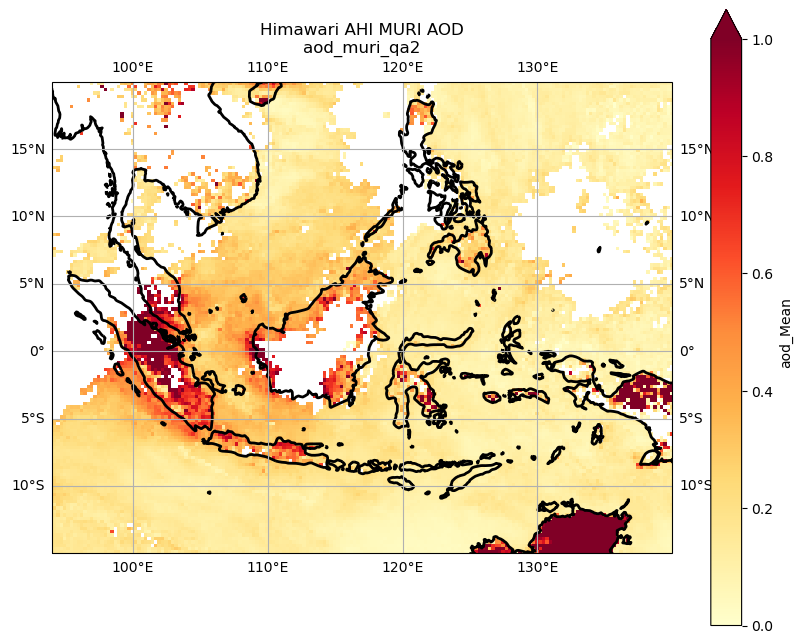

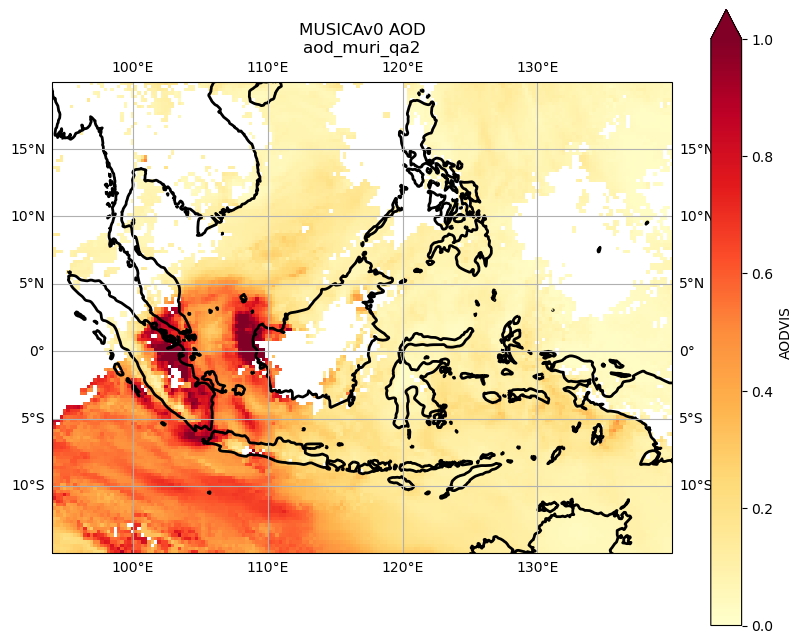

In [14]:
for group_name in group_name_list:
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max =140
    latitude_min = -15  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    mean_aod.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title(f'Himawari AHI MURI AOD\n{group_name}')
    plt.savefig(f'img/daily_aod_{group_name}.png',dpi=300)
    ########################################################################
    ########################################################################
    ########################################################################
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max = 140
    latitude_min = -15  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    mean_aod_model.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title(f'MUSICAv0 AOD\n{group_name}')
    plt.savefig(f'img/daily_aod_model_seacut_{group_name}.png',dpi=300)
    
    ########################################################################
    ########################################################################
    ########################################################################

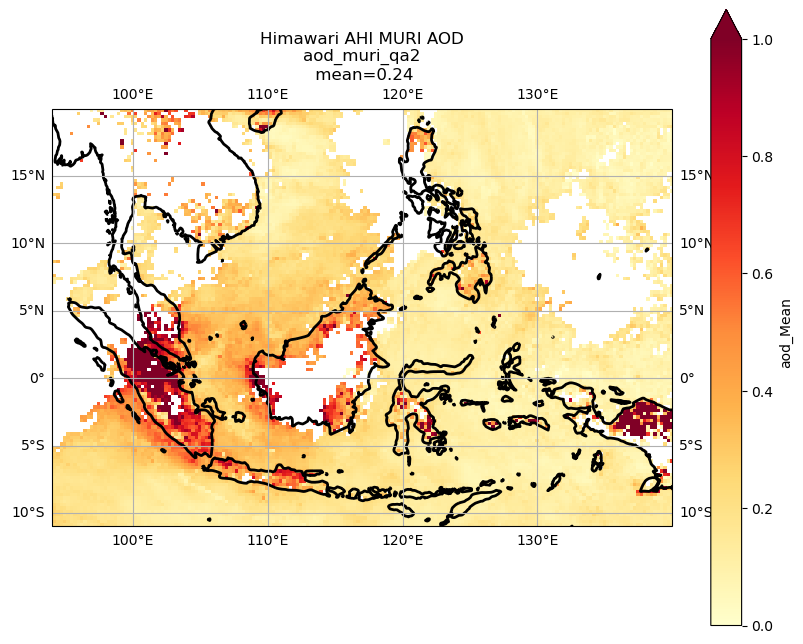

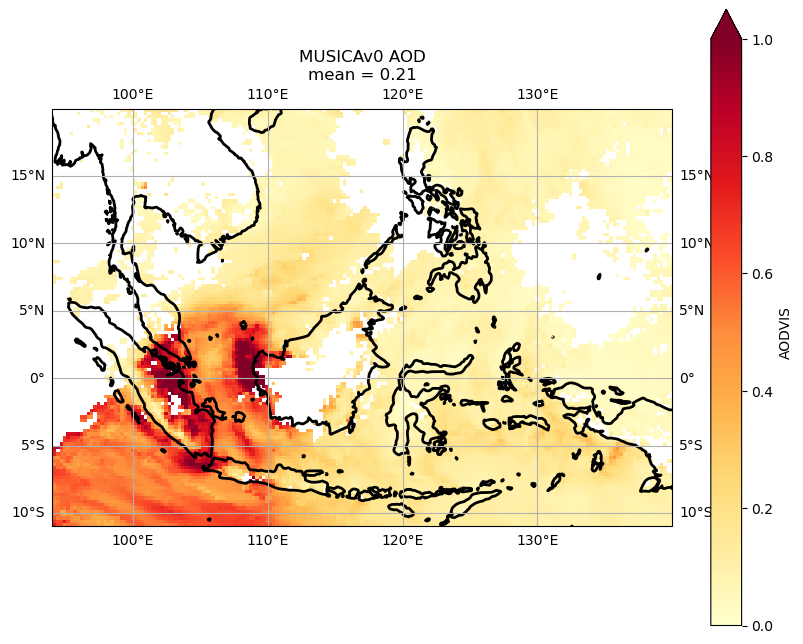

In [15]:
for group_name in group_name_list:
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max =140
    latitude_min = -11  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    mean_aod.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ahi_mean = mean_aod.where((mean_aod.latitude >= -11) & (mean_aod >=0)).mean().item()
    plt.title(f'Himawari AHI MURI AOD\n{group_name}\n mean={ahi_mean:.2f}')
    plt.savefig(f'img/daily_aod_{group_name}_v2.png',dpi=300)
    ########################################################################
    ########################################################################
    ########################################################################
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max = 140
    latitude_min = -11  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())
    
    mean_aod_model.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    musicav0_mean = mean_aod_model.where((mean_aod_model.lat >= -11) & (mean_aod >=0)).mean().item()
    plt.title(f'MUSICAv0 AOD\nmean = {musicav0_mean:.2f}')
    plt.savefig(f'img/daily_aod_model_seacut_{group_name}_v2.png',dpi=300)
    
    ########################################################################
    ########################################################################
    ########################################################################

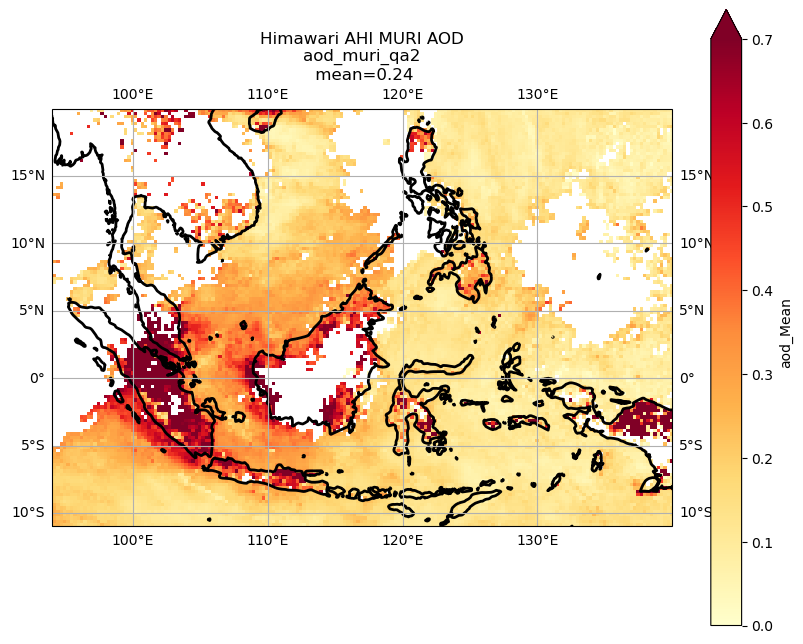

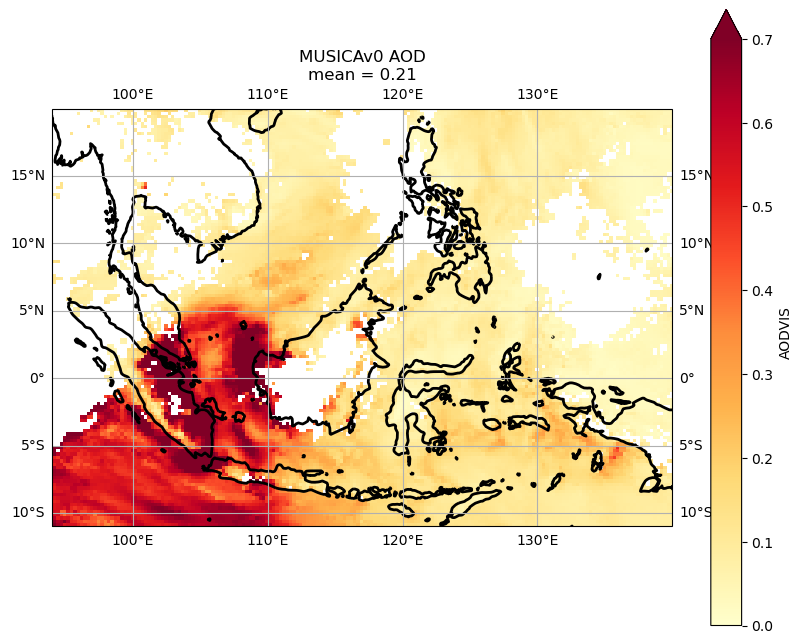

In [16]:
for group_name in group_name_list:
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max =140
    latitude_min = -11  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    mean_aod.plot.pcolormesh(vmin=0,vmax=0.7,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ahi_mean = mean_aod.where((mean_aod.latitude >= -11) & (mean_aod >=0)).mean().item()
    plt.title(f'Himawari AHI MURI AOD\n{group_name}\n mean={ahi_mean:.2f}')
    plt.savefig(f'img/daily_aod_{group_name}_v3.png',dpi=300)
    ########################################################################
    ########################################################################
    ########################################################################
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 94
    longitude_max = 140
    latitude_min = -11  # Adjust as necessary
    latitude_max = 20   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())
    
    mean_aod_model.plot.pcolormesh(vmin=0,vmax=0.7,cmap='YlOrRd')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    musicav0_mean = mean_aod_model.where((mean_aod_model.lat >= -11) & (mean_aod >=0)).mean().item()
    plt.title(f'MUSICAv0 AOD\nmean = {musicav0_mean:.2f}')
    plt.savefig(f'img/daily_aod_model_seacut_{group_name}_v3.png',dpi=300)
    
    ########################################################################
    ########################################################################
    ########################################################################

In [17]:
mean_aod.to_netcdf(f'/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_muri_{group_name}_trial.nc')


In [18]:
mean_aod

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[0.08266035, 0.08771592, 0.07799375, ..., 0.08769392, 0.0553181 ,
        0.09506713],
       [0.09148405, 0.08003423, 0.07734321, ..., 0.0744914 , 0.0636614 ,
        0.06665474],
       [0.07699582, 0.0707987 , 0.08549277, ..., 0.12486882, 0.13070325,
        0.10507503],
       ...,
       [       nan,        nan,        nan, ..., 0.06924841, 0.06666555,
        0.0477112 ],
       [       nan,        nan,        nan, ..., 0.09963956, 0.08111084,
        0.08219413],
       [       nan,        nan,        nan, ..., 0.09430194, 0.06011608,
        0.04765771]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

In [19]:
mean_aod_model.to_netcdf(f'/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0_{group_name}_trial.nc')

In [20]:
mean_aod_model

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[0.0991415 , 0.09928162, 0.10207713, ..., 0.04917015, 0.05418441,
        0.05349916],
       [0.10261737, 0.1014707 , 0.09952959, ..., 0.05260806, 0.05418441,
        0.05349916],
       [0.10289618, 0.10192212, 0.10056639, ..., 0.05260806, 0.05520283,
        0.05679346],
       ...,
       [       nan,        nan,        nan, ..., 0.04412265, 0.04748489,
        0.04723262],
       [       nan,        nan,        nan, ..., 0.04537657, 0.04796821,
        0.05147131],
       [       nan,        nan,        nan, ..., 0.04510199, 0.05041883,
        0.04819371]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [21]:
da_concat.to_netcdf(f'/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_muri_{group_name}_all_trial.nc')

In [22]:
da_concat_model.to_netcdf(f'/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0_{group_name}_all_trial.nc')

In [14]:
FILE_AHI_agg = f"/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_muri_{group_name}_all.nc"
C_AHI_agg = xarray.open_dataset(FILE_AHI_agg)
C_AHI_agg

<xarray.Dataset>
Dimensions:    (longitude: 186, latitude: 158, new_dim: 342)
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15
Dimensions without coordinates: new_dim
Data variables:
    aod_Mean   (new_dim, latitude, longitude) float64 ...

In [16]:
da_concat = C_AHI_agg['aod_Mean']
df = da_concat.to_dataframe().reset_index()
df

,new_dim,latitude,longitude,aod_Mean
0,0,-19.151599,93.940236,NaN
1,0,-19.151599,94.190410,NaN
2,0,-19.151599,94.440584,NaN
3,0,-19.151599,94.690757,NaN
4,0,-19.151599,94.940931,NaN
...,...,...,...,...
10050691,341,20.152990,139.221682,NaN
10050692,341,20.152990,139.471855,NaN
10050693,341,20.152990,139.722029,NaN
10050694,341,20.152990,139.972203,NaN


In [18]:
FILE_MUSICAv0_agg = f"/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0.nc"
C_MUSICAv0_agg = xarray.open_dataset(FILE_MUSICAv0_agg)
C_MUSICAv0_agg 


<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
Data variables:
    AODVIS   (lat, lon) float32 ...

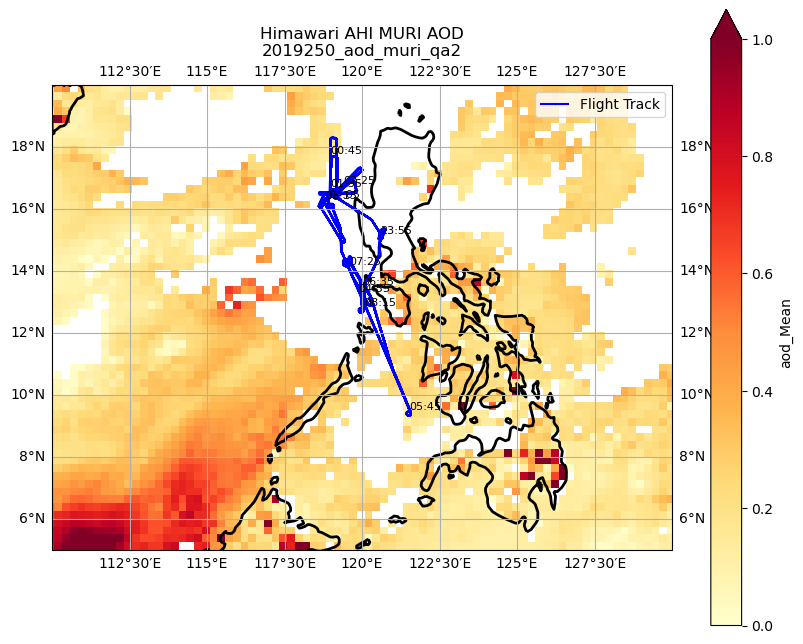

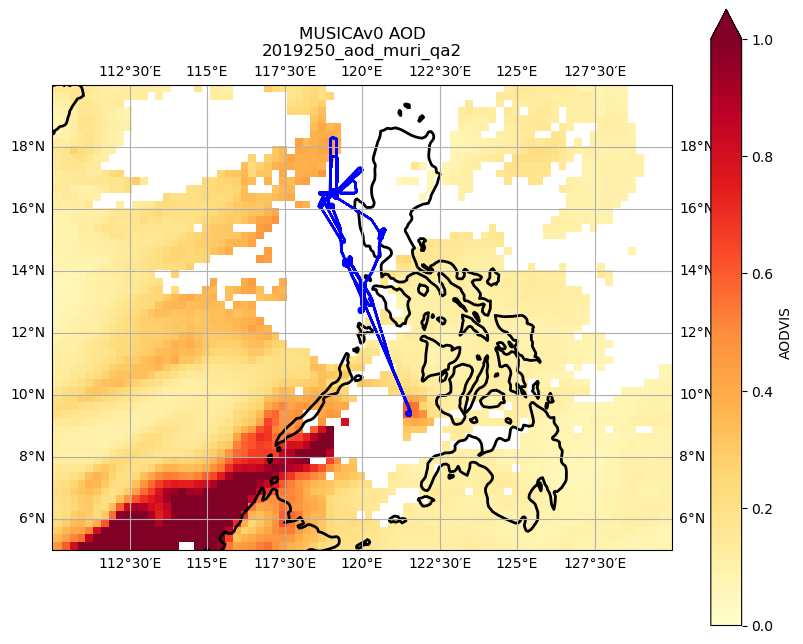

In [16]:

fig = plt.figure(figsize=(10, 8))
pla_proj = ccrs.PlateCarree()
ax = plt.axes(projection=pla_proj)

longitude_min = 94
longitude_max = 140
latitude_min = -15  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

mean_aod.where(mean_aod >=0).plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')

# Plot the flight track on the map
ax.plot(lons, lats, color='blue', marker='o', markersize=0.1, transform=ccrs.PlateCarree(), label='Flight Track')
ax.set_ylim(5,20)
ax.set_xlim(110,130)

ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Optionally, annotate the track with datetime (only label every 10th point to avoid clutter)
for i in range(0, len(lons), 3000):
    ax.text(lons[i], lats[i], datetimes[i].strftime('%H:%M'), fontsize=8, transform=ccrs.PlateCarree())

# Add title and labels
plt.title(f'Flight Track {file_date_str}')
plt.legend()

plt.title(f'Himawari AHI MURI AOD\n{file_date_str}_{group_name}')
plt.savefig(f'img/{file_date_str}_flghtrk_daily_aod_{group_name}.png',dpi=300)

########################################################################
########################################################################
########################################################################
fig = plt.figure(figsize=(10, 8))
pla_proj = ccrs.PlateCarree()
ax = plt.axes(projection=pla_proj)

longitude_min = 94
longitude_max = 140
latitude_min = -15  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

mean_aod_model.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')

# Plot the flight track on the map
ax.plot(lons, lats, color='blue', marker='o', markersize=0.1, transform=ccrs.PlateCarree(), label='Flight Track')
ax.set_ylim(5,20)
ax.set_xlim(110,130)


ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title(f'MUSICAv0 AOD\n{file_date_str}_{group_name}')
plt.savefig(f'img/{file_date_str}_flghtrk_daily_aod_model_seacut_{group_name}.png',dpi=300)


# Get Daily Average Cloud Fraction

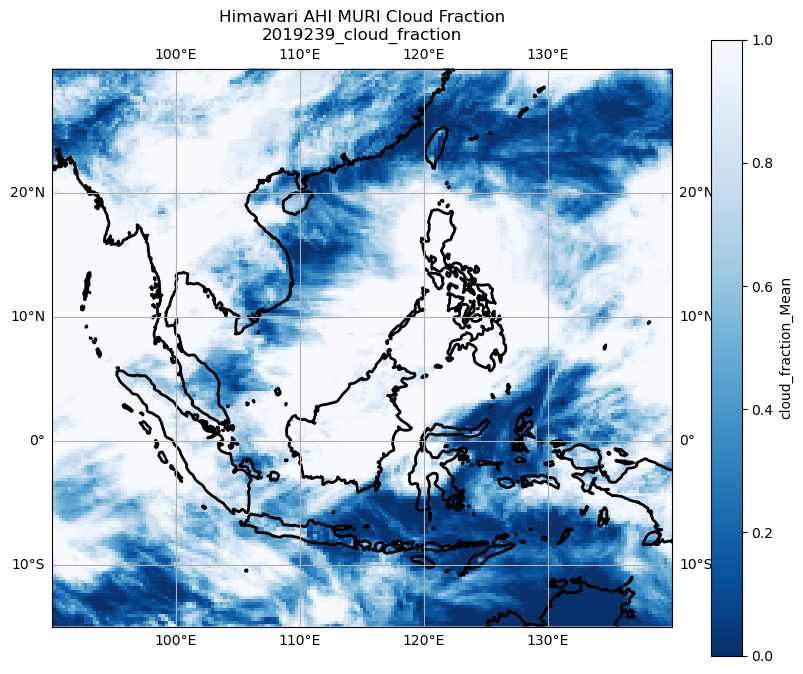

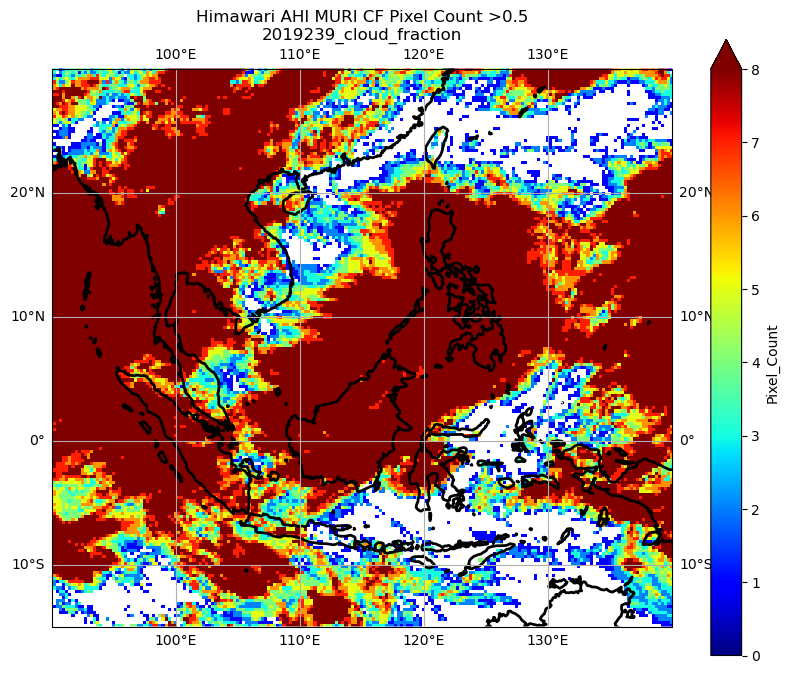

In [ ]:

group_name_list = ['cloud_fraction']
for group_name in group_name_list:
    da_concat = xarray.DataArray([])
    for i in range(0, 9, 1):
        hh = f"{i:02d}"
        FILE=f"/home/svisaga/clavrx/muri/AGGR_HOURLY_2019{dd:03}T{hh}00_0_25deg_campex_muri.nc"

        ds_cf = xarray.open_dataset(FILE, group=group_name)
        #for figure labels
        file_date_str = FILE.split('/')[-1].replace('.nc', '') .split('T')[0].split('_')[2]
        
        if i>0:
            cf_1 = da_concat #save old timestep CF to cf_1
        da_concat = ds_cf['Mean']
        if i>0:
            dataarrays = [cf_1, da_concat]
            da_concat = xarray.concat(dataarrays, dim='new_dim')  
    mean_cf = da_concat.mean(dim='new_dim', skipna=True)
    mean_cf = mean_cf.data
    cf_with_coords = xarray.DataArray(
    data=mean_cf.T,  # Cloud Fraction data values
    dims=['latitude', 'longitude'],   # Specify the dimension names
    coords={'longitude': longitude, 'latitude': latitude},  # Assign coordinates
    name='cloud_fraction_Mean'  # You can name the DataArray
    )

    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 90
    longitude_max = 140
    latitude_min = -15  # Adjust as necessary
    latitude_max = 30   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    cf_with_coords.where(cf_with_coords >=0).plot.pcolormesh(vmin=0,vmax=1,cmap='Blues_r')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title(f'Himawari AHI MURI Cloud Fraction\n{file_date_str}_{group_name}')
    plt.savefig(f'img/{file_date_str}_daily_cf_{group_name}.png',dpi=300)
    
    ########################################################################
    ########################################################################
    ########################################################################
    #mean_pixelcount = da_concat.count(dim='new_dim')
    mean_pixelcount = (da_concat>0.5).sum(dim='new_dim')
    mean_pixelcount = mean_pixelcount.data
    pcqa_with_coords = xarray.DataArray(
        data=mean_pixelcount.T,  
        dims=['latitude', 'longitude'],   # Specify the dimension names
        coords={'longitude': longitude, 'latitude': latitude},  # Assign coordinates
        name='Pixel_Count'  # You can name the DataArray
    )
    
    fig = plt.figure(figsize=(10, 8))
    pla_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=pla_proj)

    longitude_min = 90
    longitude_max = 140
    latitude_min = -15  # Adjust as necessary
    latitude_max = 30   # Adjust as necessary
    ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

    pcqa_with_coords.where(pcqa_with_coords >=1).plot.pcolormesh(vmin=0,vmax=8,cmap='jet')
    
    ax.coastlines(resolution='50m', color='black', linewidth=2)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    plt.title(f'Himawari AHI MURI CF Pixel Count >0.5\n{file_date_str}_{group_name}')
    plt.savefig(f'img/{file_date_str}_daily_cfpixelcount_{group_name}.png',dpi=300)